In [96]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from model import Net

net = Net()
# print(net)
# net.load_state_dict(torch.load('savedModels/TrainedFRModel.pt'))
# net.eval()

In [98]:
from FacePointsDataset import FacePointsDataset
from FacePointsDataset import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(256),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])



transformed_dataset = FacePointsDataset(csv_file='data/train-test-data/training_frames_keypoints.csv',
                                             root_dir='data/train-test-data/training/',
                                             transform=data_transform)



# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [99]:
batch_size = 10
train_loader = DataLoader(transformed_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)

In [100]:
test_dataset = FacePointsDataset(csv_file='data/train-test-data/test_frames_keypoints.csv',
                                             root_dir='data/train-test-data/test/',
                                             transform=data_transform)

In [101]:
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [102]:
def net_sample_output():
    
    for i, sample in enumerate(test_loader):
        
        images = sample['image']
        key_pts = sample['keypoints']

        images = Variable(images)
        images = images.type(torch.FloatTensor)

        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        if i == 0:
            return images, output_pts, key_pts

In [103]:
test_images, test_outputs, gt_pts = net_sample_output()

In [104]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [105]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        image = test_images[i].data
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call i


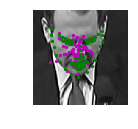

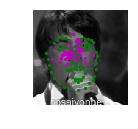

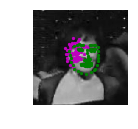

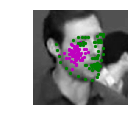

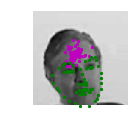

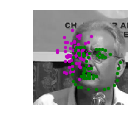

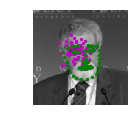

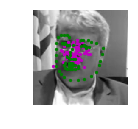

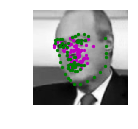

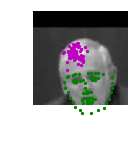

In [106]:
visualize_output(test_images, test_outputs, gt_pts)

In [107]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False)

In [108]:
def train_net(n_epochs):
    net.train()

    for epoch in range(n_epochs):
        
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']

            key_pts = key_pts.view(key_pts.size(0), -1)
            images, key_pts = Variable(images), Variable(key_pts)

            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = net(images)

            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()

            running_loss += loss.data[0]
            if batch_i % 10 == 9:
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [110]:
n_epochs = 5
train_net(n_epochs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1, Batch: 10, Avg. Loss: 0.0005516906385309994
Epoch: 1, Batch: 20, Avg. Loss: 0.0005484713474288583
Epoch: 1, Batch: 30, Avg. Loss: 0.0004909090348519385
Epoch: 1, Batch: 40, Avg. Loss: 0.0007100930670276284
Epoch: 1, Batch: 50, Avg. Loss: 0.0005785177345387638
Epoch: 1, Batch: 60, Avg. Loss: 0.0005712530692107975
Epoch: 1, Batch: 70, Avg. Loss: 0.0005666071083396673
Epoch: 1, Batch: 80, Avg. Loss: 0.0005375438486225903
Epoch: 1, Batch: 90, Avg. Loss: 0.000555790844373405
Epoch: 1, Batch: 100, Avg. Loss: 0.0005353309097699821
Epoch: 1, Batch: 110, Avg. Loss: 0.00046473563998006284
Epoch: 1, Batch: 120, Avg. Loss: 0.0005596886621788144
Epoch: 1, Batch: 130, Avg. Loss: 0.0006398166297003627
Epoch: 1, Batch: 140, Avg. Loss: 0.0004976699710823596
Epoch: 1, Batch: 150, Avg. Loss: 0.0005188750801607966
Epoch: 1, Batch: 160, Avg. Loss: 0.0005689801182597876
Epoch: 1, Batch: 170, Avg. Loss: 0.0004820633912459016
Epoch: 1, Batch: 180, Avg. Loss: 0.0005709207034669816
Epoch: 1, Batch: 19

Epoch: 5, Batch: 150, Avg. Loss: 0.00045181356836110353
Epoch: 5, Batch: 160, Avg. Loss: 0.0003705158014781773
Epoch: 5, Batch: 170, Avg. Loss: 0.0005258812452666461
Epoch: 5, Batch: 180, Avg. Loss: 0.00037538562901318073
Epoch: 5, Batch: 190, Avg. Loss: 0.00038977741496637464
Epoch: 5, Batch: 200, Avg. Loss: 0.00044371926924213767
Epoch: 5, Batch: 210, Avg. Loss: 0.0005590614746324718
Epoch: 5, Batch: 220, Avg. Loss: 0.0002912911877501756
Epoch: 5, Batch: 230, Avg. Loss: 0.00046477990690618753
Epoch: 5, Batch: 240, Avg. Loss: 0.0006161705823615193
Epoch: 5, Batch: 250, Avg. Loss: 0.00074134481837973
Epoch: 5, Batch: 260, Avg. Loss: 0.0004893524455837905
Epoch: 5, Batch: 270, Avg. Loss: 0.00039250063127838075
Epoch: 5, Batch: 280, Avg. Loss: 0.0003468421346042305
Epoch: 5, Batch: 290, Avg. Loss: 0.0004510829458013177
Epoch: 5, Batch: 300, Avg. Loss: 0.0003557476447895169
Epoch: 5, Batch: 310, Avg. Loss: 0.0002814894251059741
Epoch: 5, Batch: 320, Avg. Loss: 0.0002941153652500361
Epoch:

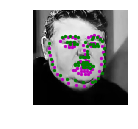

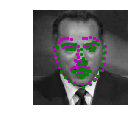

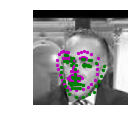

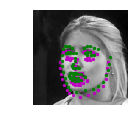

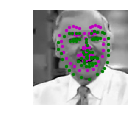

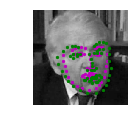

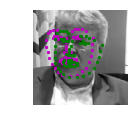

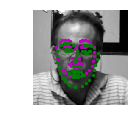

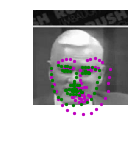

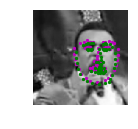

In [111]:
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [112]:
model_dir = 'savedModels/'
model_name = 'TrainedFRModel.1.pt'

torch.save(net.state_dict(), model_dir+model_name)

[[-0.07475854]]
(1, 1)


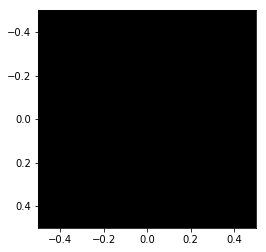

In [126]:
weights1 = net.conv5.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

plt.imshow(w[filter_index][0], cmap='gray')

torch.Size([1, 224, 224])


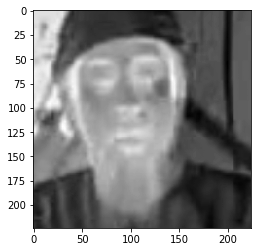

In [127]:
import cv2

kernel = w[23][0]
data = next(iter(test_loader))
print(data['image'][0].shape)
image = data['image'][0] 
image = image.numpy()
image = np.transpose(image, (1, 2, 0)) 

image = cv2.filter2D(image, -1, kernel)
plt.imshow(np.squeeze(image), cmap='gray')